In [1]:
import pykevlar.core as core
import pykevlar.driver as driver
from pykevlar.batcher import SimpleBatch
import numpy as np
import os
#import timeit

from logging import basicConfig, getLogger
# from logging import DEBUG as log_level
from logging import INFO as log_level
basicConfig(level = log_level,
            format  = '%(asctime)s %(levelname)-8s %(module)-20s: %(message)s',
            datefmt ='%Y-%m-%d %H:%M:%S')
logger = getLogger(__name__)


In [2]:

# ========== Toggleable ===============
n_arms = 2      # prioritize 3 first, then do 4
sim_size = 1E5
n_thetas_1d = 64
n_threads = os.cpu_count()
max_batch_size = 64000

logger.info("n_arms: %d, sim_size %d, n_thetas_1d: "
            "%d, n_threads: %d, max_batch_size: %d" %
            (n_arms, sim_size, n_thetas_1d,
             n_threads, max_batch_size))
# ========== End Toggleable ===============

ph2_size = 50
n_samples = 250
seed = 69
thresh = 1.96
lower = -0.5
upper = 0.5

# set numpy random seed
np.random.seed(seed)

# define null hypos
def null_hypo(i, p):
    return p[i] <= p[0]


2022-03-04 22:13:47 INFO     1673709845          : n_arms: 2, sim_size 100000, n_thetas_1d: 64, n_threads: 10, max_batch_size: 64000


In [3]:


# Create full grid.
# At the driver-level, we need to know theta, radii, sim_sizes.
theta_1d = core.Gridder.make_grid(n_thetas_1d, lower, upper)


In [4]:

grid = np.stack(np.meshgrid(*(theta_1d for _ in range(n_arms))), axis=-1) \
        .reshape(-1, n_arms)


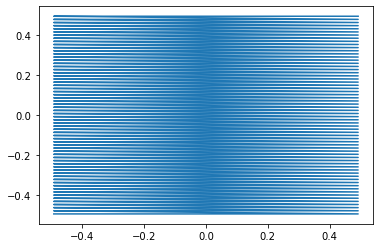

In [5]:
import matplotlib.pyplot as plt
plt.plot(grid[:,0], grid[:,1])
plt.show()

In [6]:
grid_null = np.array([
    p for p in grid if null_hypo(1, p)
])

In [7]:
grid_null.shape, grid.shape

((2080, 2), (4096, 2))

In [8]:
gr = core.GridRange(n_arms, grid_null.shape[0])

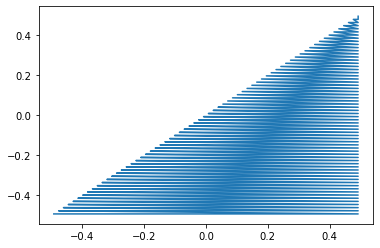

In [9]:
thetas = gr.get_thetas()
thetas[...] = np.transpose(grid_null)
plt.plot(thetas[0, :], thetas[1, :])
plt.show()


In [10]:
n_thetas_1d

64

In [11]:
radii = gr.get_radii()
radii[...] = core.Gridder.radius(n_thetas_1d, lower, upper)


In [112]:
radii[0]

array([0.0078125, 0.0078125, 0.0078125, ..., 0.0078125, 0.0078125,
       0.0078125])

In [ ]:

sim_sizes = gr.get_sim_sizes()
sim_sizes[...] = sim_size

In [12]:
sim_sizes.shape

(2080,)

In [13]:
sim_sizes

array([100000, 100000, 100000, ..., 100000, 100000, 100000], dtype=uint32)

In [14]:
# create batcher
batcher = SimpleBatch(gr, max_batch_size)

In [15]:
# create BCKT
bckt = core.BinomialControlkTreatment(n_arms, ph2_size, n_samples, [thresh])
bckt.set_grid_range(gr, null_hypo)
bckt.cov_quad(0, radii[:, 0])

0.007185376763379899

In [16]:
bckt.max_cov_quad(0, radii[:, 0])

0.007198828386218959

In [17]:
state = bckt.make_state()
from pykevlar.core import mt19937
gen = mt19937()     # TODO: maybe generalize this?
gen.seed(seed)


In [27]:
[state.get_grad(i, 0) for i in range(10)], thetas[:, :10]

([-3.844596029932421,
  -2.766042170138774,
  -3.690861594819946,
  -4.618959358374322,
  -5.5502390377761,
  -3.48460276832255,
  -0.42195128073010124,
  0.6378160604463899,
  1.6948012170980762,
  1.7491074365791515],
 array([[-0.4921875, -0.4765625, -0.4609375, -0.4453125, -0.4296875,
         -0.4140625, -0.3984375, -0.3828125, -0.3671875, -0.3515625],
        [-0.4921875, -0.4921875, -0.4921875, -0.4921875, -0.4921875,
         -0.4921875, -0.4921875, -0.4921875, -0.4921875, -0.4921875]]))

2080

In [29]:
n_gp = bckt.n_gridpts()
rej_len = np.zeros(n_gp, dtype=np.uint32)

array([0, 0, 0, ..., 0, 0, 0], dtype=uint32)

In [75]:
int(sim_size)

100000

In [87]:
from pykevlar.core import InterSum
is_o = InterSum(state.n_models(),
                state.n_gridpts(),
                state.n_params())

In [88]:
# %%time
for i in range(10000):#int(sim_size)):
    state.gen_rng(gen)
    state.gen_suff_stat()
    is_o.update(state)
    #print(np.sum(rej_len))

In [96]:
t1 = is_o.type_I_sum() / 10000

In [97]:
t1.shape

(1, 2080)

In [108]:
gs = is_o.grad_sum() / 10000
gs.shape

(4160,)

In [109]:
gs = gs.reshape((1, n_gp, 2))

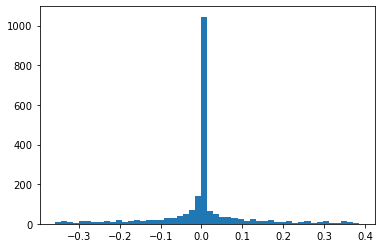

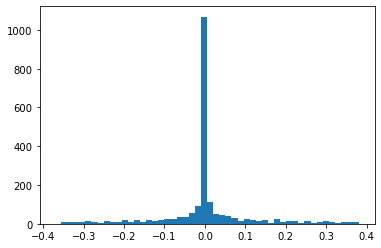

In [111]:
plt.hist(gs[0, :,0], bins=50)
plt.show()
plt.hist(gs[0, :,1], bins=50)
plt.show()

In [113]:
grid

(2080, 2)

In [ ]:
plt.contourf(grid_null[:,0], grid_null[:,1])

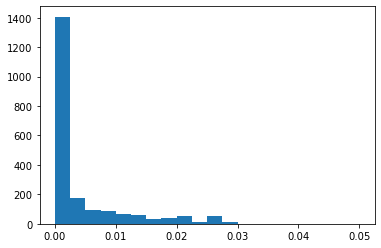

In [98]:
plt.hist(t1.T, bins=np.linspace(0.0, 0.05, 21))
plt.show()

In [30]:
np.sum(rej_len)

0

In [17]:
radii[:, 0]

array([0.0078125, 0.0078125])

In [ ]:
bckt.cov_quad(0, radii[:, 0])

In [ ]:

is_o = driver.fit_thread(bckt, sim_size, seed)
print(is_o.type_I_sum() / sim_size)

In [ ]:
class MyBinomialState:
    def __init__(self, model):
        self.model = model

    def gen_rng(self, gen):
        pass

    def gen_suff_stat(self):
        pass

class MyBinomial23(core.BinomialControlkTreatment):
    def __init__(self, n_arms, ph2_size, n_samples, thresholds):
        super().__init__(n_arms, ph2_size, n_samples, thresholds)

    def make_state(self):
        return MyBinomialState(self)